In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [165]:
plaque_markers_data = pd.read_excel('data.xlsx')

In [ ]:
plaque_markers_data.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)
plaque_markers_data.head()

In [34]:
plaque_markers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 337 entries, Case_NR to CSF-1
dtypes: float64(337)
memory usage: 553.0 KB


In [35]:
plaque_markers_data.describe()

,Case_NR,CT.TotalPV,CT.TotalNCPV,Patient ID,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,...,CX3CL1,TNFRSF9,NT-3,TWEAK,CCL20,ST1A1,STAMPB,ADA,TNFB,CSF-1
count,196.000000,196.000000,196.000000,196.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,105.479592,481.528061,155.854592,105.474490,6.740679,6.543489,3.394235,8.236911,2.027561,1.354846,...,4.767120,5.697805,1.143157,8.990595,4.807011,2.093794,5.237908,3.731962,3.337303,7.565142
std,62.400646,513.792896,252.578197,62.406972,1.366522,0.658024,0.522239,0.768538,0.419911,0.378883,...,0.507328,0.527981,0.458520,0.719401,1.132906,1.036367,1.023467,0.637937,0.471644,0.538378
min,1.000000,0.000000,0.000000,1.000000,1.754080,2.005310,0.622106,2.627157,0.042090,0.118690,...,1.700350,2.236887,0.187730,3.719430,1.257147,0.031980,0.899786,1.256259,1.087220,2.989197
25%,50.750000,76.375000,14.175000,50.750000,5.937685,6.379132,3.220745,8.073992,1.872422,1.116670,...,4.593315,5.474662,0.905120,8.838505,4.182825,1.357860,4.633915,3.413393,3.136315,7.478290
50%,103.500000,323.800000,86.950000,103.500000,6.549085,6.629000,3.413410,8.312725,2.054245,1.364865,...,4.780440,5.731590,1.108125,9.018005,4.639320,2.180635,5.256195,3.654930,3.392275,7.637180
75%,161.250000,698.175000,200.600000,161.250000,7.378807,6.843522,3.660475,8.544852,2.247275,1.629170,...,5.012250,5.974748,1.312820,9.223000,5.242328,2.706315,5.776257,3.920555,3.594257,7.757310
max,211.000000,2460.200000,1921.200000,211.000000,11.494590,8.156010,5.010560,9.766340,3.399530,2.262470,...,6.269690,6.845470,3.668650,12.957200,10.194800,6.276790,8.349580,7.835020,5.297520,8.540900


In [4]:
X = plaque_markers_data.iloc[:, 4:]
y = plaque_markers_data.iloc[:, [1,2]]



In [72]:
x = np.array([[1,2,3,4], [ 3,4,5,float('nan')]])

y = np.array([[1,2,3], [ 1,2,'banana']])

y.dtype


dtype('<U21')

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import DistanceMetric

class NN_imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, metric = 'euclidean', n_neighbors=3):
        
        self.metric = metric
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        dist = DistanceMetric.get_metric(self.metric) # used to calculate NNs
        
        sum_columns = np.sum(X, axis=1)
        
        incomplete_rows_index = np.argwhere(np.isnan(sum_columns)).flatten() # select rows where there is any missing value
        donors_rows_index = np.argwhere(np.isnan(sum_columns) == False).flatten() #select complete rows
        
        donors, incomplete_rows = X[donors_rows_index, :], X[incomplete_rows_index, :]
        
        donors = np.ma.array(donors, mask=False)
        
        for index, incomplete in enumerate(incomplete_rows):
            
            missing_values_index = np.argwhere(np.isnan(incomplete)).flatten() # the missing variables for this row
            
            donors_mask = np.ma.array(donors, mask=False)  # create mask of donor matrix to exclude the missing values when computing nearest neighbors

            donors_mask.mask[:, missing_values_index] = True
            
            sorted_neighbors = np.argsort(dist.pairwise(donors_mask, [incomplete])) # compute nearest neighbor using available variables from incomplete row
            
            nn_relevant_values = donors[:self.n_neighbors, missing_values_index] # the nns' values for the incomplete row missing variables
            
            X[incomplete_rows_index[index], missing_values_index] = np.mean(nn_relevant_values, axis=0)
            
        return X
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop=None):
        
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
                    
        X.dropna(how='all', inplace=True) # drop rows that do not have any value
                    
        if self.columns_to_drop is not None:
            X.drop(columns=self.columns_to_drop, inplace=True)
        return X.values
    
class DataNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, method='z-score'):

        self.method = method

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        if self.method == 'z-score':
            data_mean = np.nanmean(X, axis=0)
            data_std = np.nanstd(X, axis=0)

            norm_data = (X-data_mean)/data_std

            return norm_data


        elif self.method == 'minmax':

            data_min = np.nanmax(X, axis=0)
            data_max = np.nanmin(X, axis=0)

            norm_data = (X - data_min) / (data_max-data_min)

            return norm_data
                

In [240]:
from sklearn.pipeline import Pipeline


columns_to_drop = ['Unnamed: 3', 'Unnamed: 4']

pipeline_w_norm = Pipeline([
    ('selector', DataFrameSelector(columns_to_drop)),
    ('normalizer', DataNormalizer(method='z-score')),
    ('NNimputer', NN_imputer(n_neighbors=3))
])

pipeline_wout_norm = Pipeline([
    ('selector', DataFrameSelector(columns_to_drop)),
    ('NNimputer', NN_imputer(n_neighbors=4))
])

plaque_markers_data = pd.read_excel('data.xlsx')

processed_X = pipeline_wout_norm.fit_transform(plaque_markers_data)

plaque_markers_data = pd.read_excel('data.xlsx')

processed_norm_X = pipeline_w_norm.fit_transform(plaque_markers_data)
        
columns = np.ma.array(plaque_markers_data.columns, mask=False)
columns.mask[3:4] = True

processed_X_df = pd.DataFrame(processed_X, columns=columns)
processed_X_norm_df = pd.DataFrame(processed_norm_X, columns=columns)
processed_X_df

,Case_NR,CT.TotalPV,CT.TotalNCPV,Patient ID,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,...,CX3CL1,TNFRSF9,NT-3,TWEAK,CCL20,ST1A1,STAMPB,ADA,TNFB,CSF-1
0,1.0,608.9,62.900,1.0,7.566520,6.325800,3.085770,7.790850,2.159270,1.277910,...,5.539160,6.187050,0.510260,9.810210,3.416030,4.823570,5.519790,4.327650,3.254380,7.659850
1,2.0,1579.5,277.600,2.0,7.308090,6.772250,3.334420,8.385890,2.163650,1.451350,...,5.189470,6.091320,0.375460,9.315150,3.450660,4.215100,4.712570,3.921720,3.449720,7.757070
2,3.0,137.9,74.400,3.0,5.980930,5.319240,2.574940,6.800270,1.279590,0.875580,...,4.069790,5.027010,0.448620,8.860270,2.613820,4.512710,4.067100,3.288570,2.916800,6.917190
3,4.0,417.7,255.400,4.0,9.819060,5.169690,2.213940,6.670320,0.812060,0.492980,...,3.414500,4.473770,0.953310,7.593100,2.514290,0.063964,6.521340,4.586140,2.174440,5.978390
4,5.0,194.9,194.900,5.0,6.057830,6.250050,2.899070,7.883560,1.533010,0.670930,...,3.400710,4.839100,0.747170,8.123450,3.771680,0.331520,3.355780,2.803950,2.874930,6.684170
5,6.0,829.0,156.900,6.0,5.749010,7.040130,3.084540,8.695370,2.370550,1.265570,...,4.753010,5.353430,1.303940,8.929220,6.301690,2.163150,4.640710,4.393660,3.607470,7.525650
6,7.0,0.0,0.000,7.0,5.871670,7.512410,3.347330,8.379790,2.452170,1.448540,...,5.072990,6.551100,1.126340,8.759150,6.826490,1.986440,4.280640,3.542480,4.422860,8.023570
7,8.0,0.0,0.000,8.0,7.209810,6.166500,3.911360,8.387210,2.256530,1.995910,...,4.593300,4.581040,0.499920,9.106120,3.323320,1.192800,4.408860,3.078100,2.531610,7.269020
8,9.0,651.4,452.300,9.0,5.753490,7.486130,3.589080,8.176500,2.742450,1.677750,...,4.564550,6.255750,1.588400,8.900530,7.043600,1.471340,4.310240,3.402110,3.417320,7.531030
9,10.0,322.9,262.500,10.0,6.717140,7.193300,3.949510,8.977010,2.591580,2.106740,...,4.836500,5.925880,1.073280,8.944010,8.518830,1.219850,3.856960,3.364120,3.239720,7.797700


In [31]:
biomarker_correlation_pearson = processed_X_df.corr()
biomarker_correlation_spearman = processed_X_df.corr(method='spearman')

class Correlations(object):
    
    def __init__(self, data):
        
        self.data = data
        self.pearson = data.corr()
        self.spearman = data.corr(method='spearman')
        
    def get_target_highest_correlations(self, target_columns):
        
        n_samples = np.arange(0, self.data.shape[0])
        other_variables = np.ma.array(n_samples, mask=False)
        other_variables.mask[target_columns] = True
        other_variables = other_variables.compressed()
        
        var_corr = pd.concat([self.pearson.iloc[other_variables, target_columns], 
                                 self.spearman.iloc[other_variables,target_columns]], axis=1, keys=['pearson', 'spearman'])
        
        var_corr['max_corr'] = np.max(np.abs(var_corr.values), axis=1)
        var_corr.sort_values(by='max_corr', inplace=True, ascending=False)
        var_corr['corr_diff_ratio'] = (var_corr['spearman'] - var_corr['pearson'])/(np.abs(var_corr['spearman']) + np.abs(var_corr['pearson']))
        var_corr = var_corr.reindex(['max_corr', 'spearman','pearson', 'corr_diff_ratio' ], axis=1)

        return var_corr
        
corrs = Correlations(processed_X_df)

var_corr_w_total_PV = corrs.get_target_highest_correlations(1)

var_corr_w_total_PV


,max_corr,spearman,pearson,corr_diff_ratio
CT.TotalNCPV,0.848872,0.848872,0.763219,0.053132
MMP12,0.262359,0.262359,0.172360,0.207029
REN,0.252186,0.252186,0.203338,0.107236
PGF,0.225042,0.225042,0.055053,0.606899
TRAIL-R2,0.216681,0.199603,0.216681,-0.041025
LPL,0.200676,-0.200676,-0.156627,-0.123280
FS,0.190400,0.190400,0.046277,0.608943
IGFBP3,0.190349,-0.190349,-0.121919,-0.219140
PRSS8,0.190146,0.190146,0.059548,0.523033
SELL,0.186626,-0.186626,-0.104513,-0.282041


In [32]:
var_corr_NCPV = corrs.get_target_highest_correlations(2)
var_corr_NCPV

,max_corr,spearman,pearson,corr_diff_ratio
CT.TotalPV,0.848872,0.848872,0.763219,0.053132
TRAIL-R2,0.262635,0.159108,0.262635,-0.245475
REN,0.241238,0.241238,0.130904,0.296484
LYVE1,0.216598,-0.216598,-0.063637,-0.545829
MMP12,0.211514,0.211514,0.133803,0.225042
PGF,0.203262,0.203262,0.050699,0.600736
IL18,0.199688,0.199688,0.069506,0.483598
PLA2G7,0.199238,0.199238,0.175544,0.063220
GDF-2,0.196923,-0.196923,-0.108378,-0.290026
IGFBP3,0.193747,-0.193747,-0.074067,-0.446877


In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, explained_variance_score, accuracy_score

param_grid = { 
           "n_estimators" : [100, 1000, 2500, 5000, 10000, 15000],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30, 60],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 20]}

rf = RandomForestClassifier(n_estimators=200, oob_score=True)
svc = SVC(gamma=2, C=1)

# CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10)
# CV_rfc.fit(processed_X_df.iloc[:, 5:], plaque_class)
# print CV_rfc.best_params_


first_quantile = processed_X_df.iloc[:,2].quantile(.25)
plaque_class =  processed_X_df.iloc[:,2]<first_quantile
plaque_class_c =  pd.cut(processed_X_df.iloc[:,1], 5, labels = False)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, train_size=0.7)
ss = ShuffleSplit(n_splits=20, test_size=0.3, train_size=0.7)

pca=PCA(n_components=0.9)

X = processed_X_df.iloc[:, 4:]
y = processed_X_df.iloc[:,2]
y_class = np.array(plaque_class_c)
y_class = y_class.astype(int)

reduced_X = pca.fit_transform(X)

n_splits = sss.get_n_splits(X, y)
f1_scores_rf = np.zeros((n_splits,))
f1_scores_svm = np.zeros((n_splits,))
f1_scores_rf_pca = np.zeros((n_splits,))
f1_scores_svm_pca = np.zeros((n_splits,))

accuracy_rf = np.zeros((n_splits,))
accuracy_svm = np.zeros((n_splits,))
accuracy_svm_rbf = np.zeros((n_splits,))
accuracy_rf_pca = np.zeros((n_splits,))
accuracy_svm_pca = np.zeros((n_splits,))

exp_var_scores = np.zeros((n_splits,))
loop_index = 0
f1_score_method='weighted'

for train_index, test_index in sss.split(X, y_class):
    
    ## Normalized data separation
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_class[train_index], y_class[test_index]
    
    ## PCA reduced data separation
    
    X_train_pca, X_test_pca = reduced_X[train_index, :], reduced_X[test_index, :]
    
    rf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
    svc = SVC(kernel = 'linear')
    svc_rbf = SVC()
    
    ### Fit/predict on Normalized data
    
    rf.fit(X_train, y_train)
    
    svc.fit(X_train,y_train)
    svc_rbf.fit(X_train,y_train)
    
    accuracy_rf[loop_index] = rf.score(X_test, y_test)
    accuracy_svm[loop_index] = svc.score(X_test, y_test)
    accuracy_svm_rbf[loop_index] = svc_rbf.score(X_test, y_test)
    
    y_pred_rf = rf.predict(X_test)
    y_pred_svm = svc.predict(X_test)
    
    print(rf.classes_)

    
    ### Fit/Predict on PCA reduced data
    
    rf.fit(X_train_pca, y_train)
    
    svc = SVC(kernel = 'linear')
    
    
    svc.fit(X_train_pca, y_train)
    svc_rbf.fit(X_train_pca, y_train)
    
    y_pred_rf_pca = rf.predict(X_test_pca)
    y_pred_svm_pca = svc.predict(X_test_pca)
    
    print(y_pred_rf, y_test)
    
    f1_scores_rf[loop_index] = f1_score(y_test, y_pred_rf, average=f1_score_method)
    f1_scores_svm[loop_index] = f1_score(y_test, y_pred_svm, average=f1_score_method)
    f1_scores_rf_pca[loop_index] = f1_score(y_test, y_pred_rf_pca, average=f1_score_method)
    f1_scores_svm_pca[loop_index] = f1_score(y_test, y_pred_svm_pca, average=f1_score_method)
    
    
    accuracy_svm[loop_index] = accuracy_score(y_test, y_pred_svm)
    
    accuracy_rf_pca[loop_index] = rf.score(X_test_pca, y_test)
    accuracy_svm_pca[loop_index] = svc.score(X_test_pca, y_test)
    
    loop_index = loop_index + 1

loop_index=0
    
for train_index, test_index in ss.split(X, y):
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestRegressor(n_estimators=200, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    exp_var_scores[loop_index] = explained_variance_score(y_test, y_pred)
    loop_index = loop_index + 1
    
avg_f1_score_rf = np.mean(f1_scores_rf)
avg_f1_score_svm = np.mean(f1_scores_svm)
avg_f1_score_rf_pca = np.mean(f1_scores_rf_pca)
avg_f1_score_svm_pca = np.mean(f1_scores_svm_pca)

avg_accuracy_rf = np.mean(accuracy_rf)
avg_accuracy_svm = np.mean(accuracy_svm)
avg_accuracy_svm_rbf = np.mean(accuracy_svm_rbf)
avg_accuracy_rf_pca = np.mean(accuracy_rf_pca)
avg_accuracy_svm_pca = np.mean(accuracy_svm_pca)


avg_exp_var = np.mean(exp_var_scores)

rf.oob_score_


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 2 1 0 0 0 0 1 0 0 1 0 0 0 3 3 0 0 0 1 0 0 1 0 0 0 1 2 1 1 0 2 0 0
 0 0 1 2 0 1 0 1 4 1 0 0 0 0 0 0 2 0 1 3 0 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] [1 2 1 1 0 0 0 0 0 0 0 0 1 0 1 2 0 1 2 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1
 4 0 0 2 0 0 1 0 3 0 0 0 3 2 0 0 1 0 0 0 0 3 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 1 0 1 0 3 0 0 0 0 1 0 3 0 0 0 1 0 0 2 0 0 1 0 0 1 2 0 1 0 0 0 2 0 1
 0 3 0 0 0 2 0 4 0 0 0 1 1 0 1 0 0 1 2 0 0 1 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 3 0 3 0 0 2 0 0 0 0 2 0 0 0 1 0 0 0 1 1 1 1 4 1 0 1 0 0 1 1 1 0 0 0 0 2
 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 0 0 1 0 0 2 1 2]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 3 0 0 0 0 3 1 1 0 1 0 0 0 0 2 1 2 0 0 1 0 0 1 3 0 0 0 1 0 0 1 0 0 0
 2 1 0 1 0 0 1 0 0 2 1 0 1 0 1 4 0 0 2 0 0 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [3 0 1 0 0 0 0 2 0 1 0 0 2 1 1 0 0 1 2 2 0 0 2 0 0 1 1 0 1 1 0 0 1 0 1 4 0
 0 0 0 0 1 0 0 0 0 0 0 1 3 0 3 0 1 0 0 0 0 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 3 1 1 2 1 4 0 0 0 0 0 0 2 0 3 2 1 1 0 0 1 2 0 0 1 3 0 1 1 0 0 0
 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 1 2 0 0 4 0 0 2 0 0 0 0 3 0 0 1 1 1 0 0 0 0 0 1 0 0 0 3 0 0 1 0 0 3
 0 1 1 0 0 1 0 0 2 2 0 0 0 0 2 1 0 1 0 1 0 1 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] [3 0 0 1 0 1 0 0 3 0 0 1 0 0 1 1 1 2 0 0 4 0 0 2 0 0 1 1 0 0 0 2 0 0 0 2 0
 2 0 0 0 0 1 0 1 0 3 0 0 0 0 1 0 0 0 1 0 1 1 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [2 1 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 3 0 0 0 0 4 0 0 2 1 0
 1 0 1 1 3 0 1 0 0 0 3 1 0 1 0 2 0 0 0 2 0 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 2 2 0 1 2 1 0 0 0 1 0 0 0 1 0 0 0 4 0 0 0 0 0 1 0 0 0 1 0 2 0 0 0 0 0 0
 1 0 3 0 0 1 0 2 0 0 0 1 0 3 1 0 0 1 1 0 0 3 1]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 1 0 0 0 2 0 0 1 0 2 0 0 1 0 0 0 0 1 0 0 2 1 2 0 0 3 1 0 1 0 1 0
 1 3 1 0 0 0 0 1 0 4 0 0 0 1 0 0 0 0 0 1 2 3 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 1 0 1 0 0 1 3 1 0 1 0 1 0 0 1 1 4 0 2 0 0 0 2 1 0 2 0 0 2 0 0 0
 0 3 0 0 0 2 1 0 0 0 0 1 1 0 0 0 3 0 0 0 1 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] [1 3 0 4 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 3 1 1 2 0 0 1 0 0 0
 0 3 1 0 0 2 0 0 0 2 0 0 1 0 0 1 0 1 1 2 0 1 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 3 0 0 2 0 1 0 0 0 0 1 1 2 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 3 0 0 0 1
 2 0 0 3 0 1 0 0 2 0 0 4 2 0 0 0 1 1 0 1 1 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [3 0 1 0 0 0 0 0 0 1 3 1 2 0 0 2 0 0 0 0 1 0 1 1 0 0 0 2 0 0 0 0 1 0 1 0 0
 0 1 1 4 0 0 1 0 2 0 1 1 1 0 0 0 0 2 0 0 3 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 0 0 0 0 1 0 0 0 2 0 1 0 0 1 1 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 3 0 2 0 2 1 0 0 0 0 1 0 0 4 1 3 1 0 2 1 3 0 0]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] [0 0 0 0 0 0 3 0 0 0 1 0 3 1 1 1 0 0 2 0 0 0 0 3 0 1 0 0 1 0 0 1 0 1 0 0 0
 0 0 2 0 2 0 1 0 0 0 0 1 1 1 2 0 0 4 0 1 1 0 2]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] [1 0 0 4 0 2 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 2 0 0 0 3 1 0 2 0 0 1 0 0 0
 2 1 0 1 3 1 1 1 0 0 0 0 3 0 1 0 1 2 0 0 0 0 1]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 2 0 0 3 1 1 1 0 3
 0 0 2 0 0 1 0 0 2 0 0 0 0 2 1 0 1 0 1 3 4 0 2]


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-0.33988530607165135

In [139]:
print('f1rf:{}  f1_svm:{} f1rf_pca:{}  f1_svm_pca:{}  accrf:{} acc_svm:{} acc_svm_rbf:{} accrf_pca:{} acc_svm_pca: {} exp_var:{}'.format(avg_f1_score_rf, avg_f1_score_svm, avg_f1_score_rf_pca, avg_f1_score_svm_pca, avg_accuracy_rf, avg_accuracy_svm, avg_accuracy_svm_rbf, avg_accuracy_rf_pca, avg_accuracy_svm_pca, avg_explained_variance_score))

f1rf:0.4919445673620452  f1_svm:0.45810165803043745 f1rf_pca:0.47826348947971303  f1_svm_pca:0.4552224604371472  accrf:0.615 acc_svm:0.47416666666666674 acc_svm_rbf:0.6225 accrf_pca:0.615 acc_svm_pca: 0.45166666666666666 exp_var:-0.03211253926371159


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(10,1000),
              "criterion": ["gini", "entropy"]}

# param_grid = { 
#            "n_estimators" : [100, 1000, 2500, 5000, 10000, 15000],
#            "max_depth" : [1, 5, 10, 15, 20, 25, 30, 60],
#            "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 20]}
n_iter_search=100
rf = RandomForestClassifier(oob_score=True)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
# CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10)
random_search.fit(processed_X_df.iloc[:, 5:], plaque_class)
# print(CV_rfc.best_params_)


/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do no

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8e8e3c3240>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8e8e3c3208>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8e8e3c3390>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8e8e3c3780>, 'criterion': ['gini', 'entropy']},
          pre_

In [78]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [129]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

cv = StratifiedKFold(2)

rf = RandomForestClassifier(n_estimators = 100, max_features = 5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, oob_score=True)
# rf.fit(processed_X_df.iloc[:, 5:], plaque_class)

X = processed_X_df.iloc[:, 5:]


score, permutation_scores, pvalue = permutation_test_score(
    rf, X, plaque_class, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=-1)

# importance_order = np.argsort(rf.feature_importances_)
# importance_order = importance_order[::-1]
# processed_X_df.iloc[:,5:].columns[importance_order]


In [189]:
for protein in plaque_markers_data.columns[4:]:
    print(protein)

CA1
ICAM1
CHL1
TGFBI
ENG
PLTP
SERPINA7
IGFBP3
CR2
SERPINA5
FCGR3B
IGFBP6
CDH1
CCL5
CCL14
GNLY
NOTCH1
PAM
PROC
CST3
NCAM1
PCOLCE
LILRB1
MET
IL7R
VCAM1
SELL
F11
COMP
CA4
PTPRS
MBL2
TIMP1
ANGPTL3
CD46
ITGAM
TNC
NID1
CFHR5
SPARCL1
PLXNB2
MEGF9
ANG
ST6GAL1
DPP4
REG1A
QPCT
FCN2
FETUB
CES1
CRTAC1
TCN2
PRSS2
ICAM3
SAA4
CNDP1
FCGR2A
NRP1
EFEMP1
TIMD4
FAP
TIE1
THBS4
F7
GP1BA
LYVE1
CA3
TGFBR3
DEFA1
CD59
APOM
OSMR
LILRB2
UMOD
CCL18
COL18A1
KIT
C1QTNF1
AOC3
GAS6
IGLC2
PLA2G7
TNXB
MFAP5
VASN
LILRB5
C2
BMP-6
ANG-1
ADM
CD40-L
PGF
ADAM-TS13
BOC
IL-4RA
SRC
IL-1ra
TNFRSF10A
STK4
IDUA
TNFRSF11A
PAR-1
TRAIL-R2
PRSS27
TIE2
TF
IL1RL2
PDGF subunit B
IL-27
IL-17D
CXCL1
LOX-1
Gal-9
GIF
SCF
IL18
FGF-21
PIgR
RAGE
SOD2
CTRC
FGF-23
SPON2
GH
FS
GLO1
CD84
PAPPA
SERPINA12
REN
DECR1
MERTK
KIM1
THBS2
TM
VSIG2
AMBP
PRELP
HO-1
XCL1
IL16
SORT1
CEACAM8
PTX3
PSGL-1
CCL17
CCL3
MMP7
IgG Fc receptor II-b
ITGB1BP2
DCN
Dkk-1
LPL
PRSS8
AGRP
HB-EGF
GDF-2
FABP2
THPO
MARCO
GT
BNP
MMP12
ACE2
PD-L2
CTSL1
hOSCAR
TNFRSF13B
TGM2
LEP
CA5A


In [39]:
protein_interactions_table = pd.read_csv('protein_interactions.csv', sep='\t')

In [40]:
protein_interactions_table['exp_text_avg'] = (protein_interactions_table['experimentally_determined_interaction'] + protein_interactions_table['automated_textmining'])/2 
protein_interactions_table['exp_text_avg']

0       0.9230
1       0.9025
2       0.9250
3       0.9340
4       0.9140
5       0.9195
6       0.9175
7       0.9280
8       0.9080
9       0.8960
10      0.6680
11      0.8925
12      0.7510
13      0.8855
14      0.8315
15      0.8225
16      0.6640
17      0.6430
18      0.4630
19      0.6355
20      0.6420
21      0.8060
22      0.9150
23      0.6335
24      0.6385
25      0.6175
26      0.6200
27      0.4585
28      0.6195
29      0.6160
         ...  
2502    0.2010
2503    0.2270
2504    0.2095
2505    0.1525
2506    0.2265
2507    0.1970
2508    0.2310
2509    0.2000
2510    0.1820
2511    0.2000
2512    0.1805
2513    0.2000
2514    0.2000
2515    0.2000
2516    0.2000
2517    0.2000
2518    0.2000
2519    0.2000
2520    0.1900
2521    0.2000
2522    0.2000
2523    0.2000
2524    0.2000
2525    0.2000
2526    0.2000
2527    0.1705
2528    0.2000
2529    0.1185
2530    0.2000
2531    0.2000
Name: exp_text_avg, Length: 2532, dtype: float64

In [41]:
proteins_in_data = plaque_markers_data.columns[4:]

unique_proteins_1 = protein_interactions_table.iloc[:, 0].unique()
unique_proteins_2 = protein_interactions_table.iloc[:, 1].unique()

unique_proteins = np.unique(np.r_[unique_proteins_1, unique_proteins_2])

common_proteins = np.intersect1d(unique_proteins, proteins_in_data)

mask = np.in1d(unique_proteins, proteins_in_data, invert=True)

mask_first_column = np.in1d(protein_interactions_table.iloc[:, 0], proteins_in_data)
mask_second_column = np.in1d(protein_interactions_table.iloc[:, 1], proteins_in_data)

mask_proteins = np.logical_and(mask_first_column, mask_second_column)

reduced_protein_table = protein_interactions_table.iloc[mask_proteins, :]



proteins_in_interaction_only = unique_proteins[mask]

print('number of common_proteins: {}  number of plaque_markers:{}  proteins not in plaque_markers:{}'.format(
        len(unique_proteins), len(proteins_in_data), len(proteins_in_interaction_only)))

print(proteins_in_data)
print(proteins_in_interaction_only)

number of common_proteins: 270  number of plaque_markers:333  proteins not in plaque_markers:77
Index(['CA1', 'ICAM1', 'CHL1', 'TGFBI', 'ENG', 'PLTP', 'SERPINA7', 'IGFBP3',
       'CR2', 'SERPINA5',
       ...
       'CX3CL1', 'TNFRSF9', 'NT-3', 'TWEAK', 'CCL20', 'ST1A1', 'STAMPB', 'ADA',
       'TNFB', 'CSF-1'],
      dtype='object', length=333)
['ADAMTS13' 'APOC1' 'B3GNT2' 'C19orf10' 'CASP8' 'CCL13' 'CCL2' 'CCL7'
 'CCL8' 'CD274' 'CNIH' 'CSF1' 'DKK1' 'DLK1' 'EIF4EBP1' 'EPCAM' 'F11R' 'F2R'
 'FIGF' 'FLT3LG' 'FST' 'GAL3ST4' 'GDF15' 'GPER' 'HAO1' 'HAVCR1' 'HMOX1'
 'HSPG2' 'IGFBP7' 'IKBKG' 'IL12B' 'IL15RA' 'IL17C' 'IL17D' 'IL17RA' 'IL1R2'
 'IL1RN' 'IL4R' 'IL6R' 'KITLG' 'LIFR' 'LTA' 'MCL1' 'MMP2' 'MMP3' 'MMP9'
 'MOK' 'NGF' 'NOTCH3' 'NPPB' 'NTF3' 'OLR1' 'PDCD1LG2' 'PIGR' 'PIK3C2B'
 'PLAT' 'PLAU' 'PLAUR' 'PRSS3' 'RNF31' 'SELPLG' 'SERPINE1' 'SFTPD' 'SIRPA'
 'SPP1' 'SULT2A1' 'TEK' 'TIMP2' 'TNFRSF10B' 'TNFRSF11B' 'TNFSF10' 'TNFSF11'
 'TNFSF12' 'TREML2' 'TRRAP' 'UGGT1' 'VWF']


In [142]:
interaction_matrix = pd.DataFrame(0, index=plaque_markers_data.columns[4:], columns=plaque_markers_data.columns[4:])

In [36]:
reduced_protein_table

,#node1,node2,node1_string_internal_id,node2_string_internal_id,node1_external_id,node2_external_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score,exp_text_avg
4,IL7R,IL7,1848815,1845425,9606.ENSP00000306157,9606.ENSP00000263851,0.0,0,0.0,0.000,0.000,0.866,0.9,0.962,0.999,0.89000
5,MET,HGF,1849944,1842916,9606.ENSP00000317272,9606.ENSP00000222390,0.0,0,0.0,0.000,0.000,0.875,0.9,0.964,0.999,0.89725
13,GAS6,AXL,1851398,1848254,9606.ENSP00000331831,9606.ENSP00000301178,0.0,0,0.0,0.000,0.088,0.866,0.8,0.905,0.997,0.87575
18,CXCL10,CCL5,1848754,1847396,9606.ENSP00000305651,9606.ENSP00000293272,0.0,0,0.0,0.000,0.300,0.000,0.9,0.926,0.994,0.23150
19,IL8,CCL5,1848852,1847396,9606.ENSP00000306512,9606.ENSP00000293272,0.0,0,0.0,0.000,0.071,0.360,0.9,0.911,0.994,0.49775
20,EGFR,CDH1,1846445,1844988,9606.ENSP00000275493,9606.ENSP00000261769,0.0,0,0.0,0.000,0.054,0.387,0.9,0.897,0.993,0.51450
21,TNFSF14,TNFRSF14,1864071,1853239,9606.ENSP00000469049,9606.ENSP00000347948,0.0,0,0.0,0.000,0.000,0.885,0.8,0.727,0.993,0.84550
23,TNFSF13B,TNFRSF13B,1856399,1844957,9606.ENSP00000365048,9606.ENSP00000261652,0.0,0,0.0,0.000,0.000,0.360,0.9,0.907,0.993,0.49675
26,ITGAM,ICAM1,1862188,1845628,9606.ENSP00000441691,9606.ENSP00000264832,0.0,0,0.0,0.000,0.000,0.360,0.9,0.880,0.991,0.49000
27,VEGFA,HGF,1855611,1842916,9606.ENSP00000361125,9606.ENSP00000222390,0.0,0,0.0,0.000,0.000,0.000,0.9,0.917,0.991,0.22925


In [506]:
for row in reduced_protein_table.loc[:, ['#node1', 'node2', 'exp_text_avg']].values:
    protein_1 = row[0]
    protein_2 = row[1]
    interaction_matrix.loc[protein_1, protein_2] = row[2]
    interaction_matrix.loc[protein_2, protein_1] = row[2]

for i in range(interaction_matrix.shape[0]):
    
    interaction_matrix.iloc[i,i] = 1
    
interaction_matrix.fillna(0, inplace=True)

interaction_matrix

,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,SERPINA5,...,CX3CL1,TNFRSF9,NT-3,TWEAK,CCL20,ST1A1,STAMPB,ADA,TNFB,CSF-1
CA1,1,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
ICAM1,0,1.0000,0.0000,0.000,0.2215,0.0,0.0,0.0,0.0000,0.0000,...,0.3295,0.0000,0,0,0.2405,0,0,0.0,0,0
CHL1,0,0.0000,1.0000,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
TGFBI,0,0.0000,0.0000,1.000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
ENG,0,0.2215,0.0000,0.000,1.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
PLTP,0,0.0000,0.0000,0.000,0.0000,1.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
SERPINA7,0,0.0000,0.0000,0.000,0.0000,0.0,1.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
IGFBP3,0,0.0000,0.0000,0.000,0.0000,0.0,0.0,1.0,0.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
CR2,0,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,1.0000,0.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0
SERPINA5,0,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0000,1.0000,...,0.0000,0.0000,0,0,0.0000,0,0,0.0,0,0


In [28]:
total_interation_value = np.sum(interaction_matrix, axis=1)
n_non_interacting_proteins = len(np.argwhere(total_interation_value==0))/len(total_interation_value)

print('fraction of proteins with no known interaction: {}'.format(n_non_interacting_proteins))


fraction of proteins with no known interaction: 0.42342342342342343


In [607]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as rsme


class ppi_kernel():
    def __init__(self, ppi, gamma_n, gamma_diag=False, gamma_alpha=1,
                 diagonal=False, plain_array=True, n_proteins_ensemble=False,
                 n_estimators=10, alpha_factor=10):

        '''
        Class for PPI SVM regression. Can be used as single PPI SVM or ensemble of PPI SVM regressors

        :param ppi: Protein Protein interaction matrix
        :param gamma_n: maximum length of walks allowed in the PPI matrix to compute the graph kernel
        :param gamma_alpha: how much to penalize long walks in the graph
        :param n_proteins_ensemble: how much proteins to use in each regressor if using ensemble. int or 0<float<1
        :param n_estimators: how many regressors to use if using ensemble
        :param alpha_factor: Probability ratio desired between higher connected and lower connected nodes,
        when sampling biased for ensemble
        '''

        self.ppi = ppi
        self.n_proteins = len(ppi)

        self.gamma = self.compute_exp_decay_gamma(gamma_n, alpha=gamma_alpha, diagonal=diagonal,
                                                  plain_array=plain_array)

        self.T_matrix = self.compute_transition_matrix(alpha_factor)
        self.n_estimators = n_estimators

        if not n_proteins_ensemble:

            self.n_proteins_ensemble = int(np.sqrt(self.n_proteins))

        elif n_proteins_ensemble > 1:

            self.n_proteins_ensemble = n_proteins_ensemble

        elif n_proteins_ensemble > 0:

            self.n_proteins_ensemble = int(n_proteins_ensemble * self.n_proteins)

    @staticmethod
    def mad(data):

        flat_array = data.flatten()

        n_elements = len(flat_array)

        diff_array = np.subtract.outer(flat_array, flat_array)

        return np.sum(np.abs(diff_array)) / (np.multiply(n_elements, (n_elements - 1)))

    @staticmethod
    def mp(matrix, power_number):

        '''
        Takes a matrix and a power number, and outputs an array of size n with the matrix multiplied by itself
        i times, where n is power_number and i is the index of the array +1
        :param matrix: Matrix to be exponentiated
        :param power_number: maximum number of times to multiply matrix by itself
        :return: array with matrix powers
        '''

        if power_number == 1:
            return matrix
        elif power_number == 0:
            return np.abs(matrix)
        else:

            matrix_array = [matrix]

            for i in range(1, power_number):
                matrix_array.append(np.matmul(matrix_array[i - 1], matrix))

        return matrix_array

    def compute_interaction_kernel(self, data, D=None, ppi=[], predicting=False, finishing_time=False, norm_kernel=False):

        '''
        Compute the interaction kernel. Can be used both for training and for predicting:
        Training: Pass in training data as a 2-D array
        Prediction: Pass in a list with the test samples in first entry, training samples on the second.
        WARNING: Make sure to pass D, the normalization factor obtained with training, when computing prediction kernel

        '''

        if len(ppi) == 0:
            ppi = self.ppi

        if predicting:

            n_rows = np.shape(data[0])[0]
            n_cols = np.shape(data[1])[0]

            L_array = np.array([np.outer(data[0][i, :], data[0][i, :]) for i in
                                range(n_rows)])  # Edge weight matrix for test samples
            L_prime_array = np.array([np.outer(data[1][i, :], data[1][i, :]) for i in
                                      range(n_cols)])  # Edge weight matrix for train samples

        else:

            L_array = np.array([np.outer(data[i, :], data[i, :]) for i in
                                range(len(data))])  # Edge weight matrix for train samples
            L_prime_array = L_array

        kernel_matrix = self.compute_kernel(L_array, L_prime_array, ppi=ppi, predicting=predicting,
                                            finishing_time=finishing_time)

        if norm_kernel:

            if not predicting:

                D = np.diag(1. / np.sqrt(np.diag(kernel_matrix)))
                D_prime = D

            else:

                kernel_test = self.compute_kernel(L_array, L_array, ppi, predicting=predicting,
                                                  finishing_time=finishing_time)
                D_prime = np.diag(1. / np.sqrt(np.diag(kernel_test)))

            K_norm = reduce(np.dot, (D_prime, kernel_matrix, D))

            return K_norm, D

        else:

            return kernel_matrix

    def compute_kernel(self, L_array, L_prime_array, ppi, predicting, finishing_time=False):

        n_rows = len(L_array)
        n_cols = len(L_prime_array)

        kernel_matrix = np.zeros((n_rows, n_cols))

        loop_times = []

        for i in range(n_rows):

            if finishing_time:
                start = time.time()

                print('{} % complete'.format(np.float32((i * n_cols)) / np.float32(n_cols * n_rows) * 100))

            for j in range(n_cols):

                if not predicting and j < i:

                    pass

                else:

                    kernel_matrix[i, j] = self.compute_ikernel_entry(L_array[i], L_prime_array[j], ppi.values)

                    if not predicting:

                        if j < n_rows and i != j:  # The matrix is symmetric, no need to compute twice the same value

                            kernel_matrix[j, i] = kernel_matrix[i, j]

            if finishing_time:
                end = time.time()
                loop_times.append(end - start)
                average_cycle = np.mean(loop_times)
                expected_finishing_time = average_cycle * (n_rows - i + 1) / 2
                print('average cycle time:{} \n expected finishing time: {}'.format(average_cycle,
                                                                                    expected_finishing_time))

        return kernel_matrix

    def compute_ikernel_entry(self, L, L_prime, ppi):

        gamma_n = np.shape(self.gamma)[0]

        weighted_graph_L_array = np.array(
            np.multiply(self.mp(np.multiply(ppi, L), gamma_n), self.gamma[:, np.newaxis, np.newaxis]))

        weighted_graph_L_prime_array = np.array(
            np.multiply(self.mp(np.multiply(ppi, L_prime), gamma_n), self.gamma[:, np.newaxis, np.newaxis]))

        sum_graph_L_array = np.sum(weighted_graph_L_array, axis=0)

        sum_graph_L_prime = np.sum(weighted_graph_L_prime_array, axis=0)

        result = np.sum(np.multiply(sum_graph_L_array, sum_graph_L_prime))

        return result

    @staticmethod
    def compute_exp_decay_gamma(n, alpha=1, diagonal=False, plain_array=True):

        """
        Computes the Gamma matrix
        :param: diagonal: if True, the matrix will only include non-zero elements for walks of the same length (only diagonal is non-zero)
        """

        exp_array = np.exp(-np.arange(1, n + 1) * alpha)

        if plain_array:

            return exp_array

        else:

            if diagonal:

                exp_decay_gamma = np.diag(exp_array)

            else:

                exp_decay_gamma = np.dot(exp_array[np.newaxis, :], exp_array[:, np.newaxis])

            return exp_decay_gamma

    def compute_transition_matrix(self, alpha_factor):

        '''
        Calculates transition matrix whose probability depends both on PPI connection value and
        connectivity similarity between proteins
        :param: delta: controls how much of an impact PPI value and connectivity have on the probabilities.
        the higher, the more likely it is to select groups of proteins that interact, or share similar connectivity
        '''

        c = np.sum(self.ppi.values, axis=0)
        norm_c = c / np.sum(c)
        C = np.tile(norm_c, (len(norm_c), 1))
        c_diff = C - C.T

        delta = self.ppi.values - np.abs(c_diff)

        delta_std = np.std(delta, axis=1)

        alpha = np.power(alpha_factor, np.divide(1, 2 * delta_std))

        T_matrix = np.power(alpha, delta)
        np.fill_diagonal(T_matrix, 0)

        normalization_factor = np.sum(T_matrix, axis=1)

        T_matrix = np.divide(T_matrix, normalization_factor[:, np.newaxis])

        return T_matrix

    def sample_proteins_biased(self, biased_seed):

        if biased_seed:

            first_protein = biased_seed

        else:

            first_protein = np.random.choice(
                self.n_proteins)  ### Consider not doing it randomly but more weight to the connected ones

        protein_list = [first_protein]

        protein_list[0] = first_protein

        for i in range(1, self.n_proteins_ensemble):

            new_protein = np.random.choice(self.n_proteins, 1, p=self.T_matrix[protein_list[i - 1], :])

            while new_protein in protein_list:
                new_protein = np.random.choice(self.n_proteins, 1, p=self.T_matrix[protein_list[i - 1], :])

            protein_list.extend(new_protein)

        return protein_list

    def sample_proteins_random(self):

        protein_list = np.random.choice(self.n_proteins, self.n_proteins_ensemble, replace=False)

        return protein_list

    def build_kernels(self, X_train, regressors_protein_list, predicting, D_array=None, X_test=False):

        n_regressors = len(regressors_protein_list)

        if predicting:  # TODO: refactor compute_interaction_kernel input data to prevent RY here

            regressor_kernels = []

            for i in range(n_regressors):
                regressor_kernel, _ = self.compute_interaction_kernel(
                data=[X_test[:, regressors_protein_list[i]], X_train[:, regressors_protein_list[i]]],
                ppi=self.ppi.iloc[regressors_protein_list[i], regressors_protein_list[i]],
                predicting=predicting, norm_kernel=True, D=D_array[i])
                regressor_kernels.append(regressor_kernel)

        else:

            regressor_kernels = [self.compute_interaction_kernel(
                data=X_train[:, regressors_protein_list[i]],
                ppi=self.ppi.iloc[regressors_protein_list[i], regressors_protein_list[i]],
                predicting=predicting, norm_kernel=True) for i in range(n_regressors)]

        return np.array(regressor_kernels)

    def build_regressors(self, X_training, y_training, regressors_protein_list):

        n_regressors = np.shape(regressors_protein_list)[0]

        regressor_kernels = self.build_kernels(X_training, regressors_protein_list, predicting=False)

        kernels = regressor_kernels[:, 0]
        D_array = regressor_kernels[:, 1]

        if hasattr(self, 'D_array'):
            self.D_array = np.r_[self.D_array, D_array]
        else:
            self.D_array = D_array

        regressors = np.array([[[SVR(kernel='precomputed', C=j, epsilon=k, cache_size=500, shrinking=True).fit(
                                       kernels[i],
                                       y_training)
                                for i in range(n_regressors)]
                                for j in np.geomspace(0.01, 500, 50)]
                               for k in np.linspace(0.01, 0.2, 10)])

        return regressors

    @staticmethod
    def regressors_performance_and_selection(regressors, regressor_predict_kernel, y):

        n_intermediate_regressors_eps, n_intermediate_regressors_C, n_regressors = np.shape(regressors)

        predictions = np.array([[[regressors[k][j][i].predict(regressor_predict_kernel[i])
                                for i in range(n_regressors)]
                                for j in range(n_intermediate_regressors_C)]
                                for k in range(n_intermediate_regressors_eps)])

        r2_score_array = np.array([[[r2_score(predictions[k, j, i, :], y)
                                   for i in range(n_regressors)]
                                   for j in range(n_intermediate_regressors_C)]
                                   for k in range(n_intermediate_regressors_eps)])

        best_predictors_eps = np.argmax(r2_score_array, axis=0)
        grid_indices_eps, grid_indices_reg = np.indices(np.shape(best_predictors_eps))
        r2_eps_dim_collapsed = r2_score_array[best_predictors_eps, grid_indices_eps, grid_indices_reg]
        reg_eps_dim_collapsed = regressors[best_predictors_eps, grid_indices_eps, grid_indices_reg]
        best_predictors_C = np.argmax(r2_eps_dim_collapsed, axis=0)

        regressors = reg_eps_dim_collapsed[best_predictors_C, np.arange(n_regressors)]  # select only best predictors

        r2_score_array = r2_eps_dim_collapsed[best_predictors_C, np.arange(n_regressors)]

        return regressors, r2_score_array

    def seed_and_test_biased_regressors(self, X_training, X_validation, y_training, y_validation,
                                        n_regressors, biased_seed=[]):

        '''
        Samples protein subsets and Evaluates performance of each PPI regressor on the validation set.
        If sampling protein subset using already cherrypicked proteins, pass in the list of proteins numbers
        to seed on the argument biased
        :param X_training: Data to be used to train the regressors
        :param X_validation: Data to be used for Validation
        :param y_training: Target to learn
        :param y_validation: Target to test the regressors
        :param n_regressors: Number of regressors to create/evaluate
        :param biased_seed: If selecting best performance proteins as seeds, pass in list of protein numbers
        :return:
        '''

        if len(biased_seed) == 0:
            biased_seed = [False] * n_regressors

        regressors_protein_list = np.array([self.sample_proteins_biased(biased_seed[i]) for i in range(n_regressors)])

        regressors = self.build_regressors(X_training, y_training, regressors_protein_list)

        regressor_kernels_validation = self.build_kernels(X_train=X_training,
                                                          regressors_protein_list=regressors_protein_list,
                                                          predicting=True, D_array=self.D_array, X_test=X_validation)

        regressors, r2_score_array = self.regressors_performance_and_selection(regressors,
                                                                               regressor_kernels_validation,
                                                                               y_validation)

        return regressors, regressors_protein_list, r2_score_array

    def select_biased_regressors(self, X_training, y_training, X_validation, y_validation):

        explorer_regressors, pioneer_proteins, exploration_scores = self.seed_and_test_biased_regressors(
            X_training=X_training,
            X_validation=X_validation,
            y_training=y_training,
            y_validation=y_validation,
            n_regressors=int(self.n_estimators / 2))

        exploration_mad = self.mad(exploration_scores)

        selected_pioneers = np.array(np.where(exploration_scores >
                                              np.max(exploration_scores - exploration_mad))).flatten()

        selected_regressors = explorer_regressors[selected_pioneers]

        self.D_array = self.D_array[selected_pioneers]

        ##  Use Best protein combinations repeatedly as seeds for remaining regressors

        n_remaining_regressors = self.n_estimators - np.shape(selected_pioneers)[-1]

        n_seed_repeat, n_seed_remainder = np.divmod(n_remaining_regressors, np.shape(selected_pioneers)[-1])

        ordered_scores = np.argsort(exploration_scores[selected_pioneers])

        repeated_seeds_index = np.tile(selected_pioneers[ordered_scores[::-1]],
                                         n_seed_repeat)  # TODO: careful because repeat is not cycling array but repeating each element n times before the next

        remainder_seeds_index = selected_pioneers[ordered_scores[:-n_seed_remainder - 1:-1]]

        selected_protein_seeds = pioneer_proteins[0, np.r_[repeated_seeds_index, remainder_seeds_index]]

        natural_selection_regressors, natural_selection_proteins, \
        natural_selection_scores = self.seed_and_test_biased_regressors(X_training=X_training,
                                                                        X_validation=X_validation,
                                                                        y_training=y_training,
                                                                        y_validation=y_validation,
                                                                        n_regressors=len(selected_protein_seeds),
                                                                        biased_seed=selected_protein_seeds)

        regressors = np.r_[selected_regressors, natural_selection_regressors]
        regressors_proteins = np.r_[pioneer_proteins[selected_pioneers], natural_selection_proteins]
        r2_scores = np.r_[exploration_scores[selected_pioneers], natural_selection_scores]

        cream_of_the_cream_mad = self.mad(r2_scores)  # Perform a final fitness selection of the regressors

        final_selection = np.array(np.where(np.logical_and(r2_scores >
                                            np.max(r2_scores - cream_of_the_cream_mad),
                                                r2_scores > 0))).flatten()

        self.D_array = self.D_array[final_selection]

        self.regressors = regressors[final_selection]

        self.regressors_protein_list = regressors_proteins[final_selection]

        self.X_train = X_training

        self.n_estimators = len(final_selection)

        return r2_scores[final_selection]

    def fit_ensemble_svm(self, X_train, y_train, random=False, holdout=0.2):

        train_len = int((1 - holdout) * len(X_train))

        X_training = X_train[:train_len, :]
        X_validation = X_train[train_len:, :]
        y_training = y_train[:train_len]
        y_validation = y_train[train_len:]

        if random:

            regressors_protein_list = [self.sample_proteins_random() for i in range(self.n_estimators)]
            regressors = self.build_regressors(X_training=X_training, y_training=y_training,
                                               regressors_protein_list=regressors_protein_list)
            kernel_validation = self.build_kernels(X_train=X_training, regressors_protein_list=regressors_protein_list,
                                                  predicting=True, D_array=self.D_array, X_test=X_validation)

            regressors, r2_score_array = self.regressors_performance_and_selection(regressors=regressors,
                                                                                   regressor_predict_kernel=kernel_validation,
                                                                                   y=y_validation)

            self.regressors = regressors
            self.regressors_protein_list = regressors_protein_list
            self.X_train = X_training

        else:

            r2_score_array = self.select_biased_regressors(X_training=X_training, y_training=y_training,
                                                           X_validation=X_validation, y_validation=y_validation)

        r2_score_array_ = np.power(self.n_estimators, r2_score_array)
        r2_score_array_ /= np.sum(r2_score_array_)

        self.ensemble_weights = r2_score_array_

    def ensemble_predict(self, X_test):

        regressor_kernels = self.build_kernels(X_train=self.X_train,
                                               regressors_protein_list=self.regressors_protein_list,
                                               predicting=True, X_test=X_test, D_array=self.D_array)

        predictions = np.array([self.regressors[i].predict(regressor_kernels[i]) for i in range(self.n_estimators)])

        prediction = np.sum(predictions * np.array(self.ensemble_weights)[:, np.newaxis], axis=0)

        return prediction



In [27]:
ppi_kernel = ppi_kernel()

exp_decay_gamma = ppi_kernel.compute_exp_decay_gamma(4)

ppi = interaction_matrix

kernel = compute_interaction_kernel(data=processed_X_df.iloc[:50,4:].values, gamma=exp_decay_gamma, ppi=ppi, finishing_time=True)

0.0 % complete
average cycle time:1.6734809875488281 
 expected finishing time: 42.67376518249512
1.9999999552965164 % complete
average cycle time:1.6299986839294434 
 expected finishing time: 40.749967098236084
3.999999910593033 % complete
average cycle time:1.6046396891276042 
 expected finishing time: 39.313672383626304
5.999999865889549 % complete
average cycle time:1.5901786088943481 
 expected finishing time: 38.164286613464355
7.999999821186066 % complete
average cycle time:1.5816903591156006 
 expected finishing time: 37.16972343921662
10.000000149011612 % complete
average cycle time:1.5854885578155518 
 expected finishing time: 36.46623682975769
11.999999731779099 % complete
average cycle time:1.5629120554242815 
 expected finishing time: 35.165521247046335
14.000000059604645 % complete
average cycle time:1.557815819978714 
 expected finishing time: 34.27194803953171
15.999999642372131 % complete
average cycle time:1.5513243410322402 
 expected finishing time: 33.3534733321931

In [56]:
# np.save('kernel_whole_pop_gamma2', kernel)

In [109]:
kernel.shape

(50, 50)

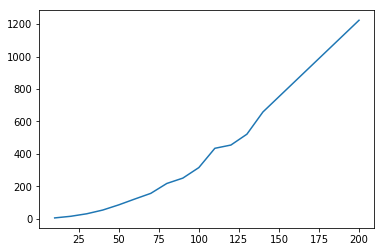

In [86]:
%matplotlib inline

training_size_array = [10, 20,30,40,50,60, 70, 80, 90, 100,110, 120, 130, 140, 200]
training_time_array = [4.5, 14.5, 30, 53, 85, 121, 156, 217, 250, 315, 434, 454, 521, 658, 1224]

plt.plot(training_size_array, training_time_array)


In [216]:
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

X = processed_X_norm_df.iloc[:-2, 4:].values  ## last two measurements do not have plaque levels

random_cols = np.random.choice(np.arange(0,X.shape[1]), 80)

X = X[:, random_cols]

# y = plaque_markers_data.iloc[:,1]

# y = y.dropna().values

y = processed_X_df.iloc[:-2, 1].values

print(X.shape[0], y.shape[0])

ppi = interaction_matrix.iloc[random_cols, random_cols]

ppi_kernel = ppi_kernel(ppi=ppi, gamma_n=4)


# ppi = interaction_matrix

test_size = np.linspace(0.75, 0.25, 5)
n_splits = 3

rsme_ppi = np.zeros((n_splits, len(test_size)))
rsme_linear = np.zeros((n_splits, len(test_size)))

for t_index, t_size in enumerate(test_size):
    
    ss = ShuffleSplit(n_splits = n_splits, test_size = t_size, random_state=0)
    
    split = 0

    for train_index, test_index in ss.split(X):

        X_train, X_test = X[train_index, :], X[test_index, :]

        y_train, y_test = y[train_index], y[test_index]
        
        train_kernel = ppi_kernel.compute_interaction_kernel(data=X_train, finishing_time=True, norm_kernel=True)

        svr_ppi = SVR(kernel='precomputed')
        
        svr_ppi.fit(train_kernel, y_train)
        
        linear_svr = SVR(kernel='linear')
        
        linear_svr.fit(X_train, y_train)
        
        svm_predict_data = [X_test, X_train]
        
        predict_kernel = ppi_kernel.compute_interaction_kernel(data=svm_predict_data, predicting=True, norm_kernel=True)
        
        y_pred_ppi_kernel = svr_ppi.predict(predict_kernel)
        y_pred_linear_kernel = linear_svr.predict(X_test)
        


        rms_ppi = np.sqrt(mean_squared_error(y_test, y_pred_ppi_kernel))
        rms_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear_kernel))
        
        rsme_ppi[split, t_index] = rms_ppi
        rsme_linear[split, t_index] = rms_linear
        
        print('rsme ppi:{}, rsme linear:{}'. format(rms_ppi, rms_linear))
        
        split = split + 1
        
    
    

196 196
0.0 % complete
average cycle time:0.12818264961242676 
 expected finishing time: 3.204566240310669
2.0408162847161293 % complete
average cycle time:0.13688600063323975 
 expected finishing time: 3.353707015514374
4.081632569432259 % complete
average cycle time:0.13288005193074545 
 expected finishing time: 3.1891212463378906
6.122449040412903 % complete
average cycle time:0.13876694440841675 
 expected finishing time: 3.2610231935977936
8.163265138864517 % complete
average cycle time:0.13747425079345704 
 expected finishing time: 3.161907768249512
10.204081982374191 % complete
average cycle time:0.13903888066609701 
 expected finishing time: 3.1283748149871826
12.244898080825806 % complete
average cycle time:0.1364445686340332 
 expected finishing time: 3.0017805099487305
14.28571492433548 % complete
average cycle time:0.13509094715118408 
 expected finishing time: 2.9044553637504578
16.326530277729034 % complete
average cycle time:0.1369856728447808 
 expected finishing time: 

KeyboardInterrupt: 

In [154]:
# np.save('rsme_ppi_first_attempt', rsme_ppi)
# np.save('rsme_linear_first_attempt', rsme_linear)

In [60]:
print('RSME_norm_PPI_non_norm_Xy_random_80 \n test_size: 75%:{}, 625%:{}, 50%:{}, 37.5%:{} 25%{} \n \n RSME_linear_SVR_nonnorm_Xy_random80:\n test_size: 75%:{}, 625%:{}, 50%:{}, 37.5%:{} 25%{} '.format(*np.mean(rsme_ppi, axis=0), *np.mean(rsme_linear, axis=0)))

RSME_norm_PPI_non_norm_Xy_random_80 
 test_size: 75%:557.2518174140806, 625%:543.2863678153512, 50%:541.6673584493525, 37.5%:552.8310591855336 25%524.5838997337477 
 
 RSME_linear_SVR_nonnorm_Xy_random80:
 test_size: 75%:555.7089947626055, 625%:554.7309138737966, 50%:550.9099813590285, 37.5%:559.764297425087 25%521.6016968020771 


In [ ]:
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6)

all_columns = X_processed_df.columns

explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=all_columns[4:], class_names=all_columns[1], verbose=True, mode='regression')

ppi_kernel = ppi_kernel(ppi, gamma_n=4)

train_kernel = compute_interaction_kernel(data=X_train, finishing_time=True)

svr_ppi = SVR(kernel='precomputed')

svr_ppi.fit(train_kernel, y_train)

i = 10

def ppi_predict(instance):
    
    svm_predict_data = [instance, X_train]
    
    predict_kernel = compute_interaction_kernel(data=svm_predict_data, predicting=True)
    
    y_pred_ppi_kernel = svr_ppi.predict(predict_kernel)
    
    return y_pred_ppi_kernel
    
exp = explainer.explain_instance(X_test[i], ppi_predict, num_features=10)

In [294]:
dot_products = np.dot(processed_X_norm_df.iloc[:-2, 4:].values, processed_X_norm_df.iloc[:-2, 4:].values.T)

print('max_prod:{}, min_prod:{}'.format(np.max(dot_products), np.min(dot_products)))

max_prod:2054.286767697859, min_prod:-762.1366148200607


In [ ]:
RSME_norm_PPI_non_norm_Xy_random_80 
 test_size: 75%:557.2518174140806, 625%:543.2863678153512, 50%:541.6673584493525, 37.5%:552.8310591855336 25%524.5838997337477 
 
 RSME_linear_SVR_nonnorm_Xy_random80:
 test_size: 75%:555.7089947626055, 625%:554.7309138737966, 50%:550.9099813590285, 37.5%:559.764297425087 25%521.6016968020771 

In [596]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import RepeatedKFold

X = processed_X_norm_df.iloc[:-2, 4:].values  ## last two measurements do not have plaque levels

# random_cols = np.random.choice(np.arange(0, X.shape[1]), 80)

# X = X[:, random_cols]

# y = plaque_markers_data.iloc[:,1]

# y = y.dropna().values

y = processed_X_df.iloc[:-2, 1].values

print(X.shape[0], y.shape[0])

# ppi = interaction_matrix.iloc[random_cols, random_cols]
# ppi = interaction_matrix

# PPI_kernel = ppi_kernel(ppi=ppi, gamma_n=4, gamma_alpha=1)

# y[np.argwhere(y > 500)] = 500

n_splits = 4

n_repeats = 5

r2_rfr = np.zeros((0, n_splits * n_repeats))

print(r2_rfr.shape)

r2_linear_svm = np.zeros((0, n_splits * n_repeats))

r2_ppi_biased_3 = np.zeros((0, n_splits * n_repeats))
r2_ppi_biased_4 = np.zeros((0, n_splits * n_repeats))
r2_ppi_biased_5 = np.zeros((0, n_splits * n_repeats))

r2_ppi_random = np.zeros((0, n_splits * n_repeats))

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

loop_index = 0 

ppi_all_results_array_3 = []
ppi_all_results_array_4 = []
ppi_all_results_array_5 = []

for train_index, test_index in rkf.split(X):

    X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

    # train_ppi_kernel = PPI_kernel.compute_interaction_kernel(data=X_train, finishing_time=False, norm_kernel=True)

    # svr_ppi = SVR(kernel='precomputed', C=100, epsilon=0.2)

    svr_en_ppi_random = ppi_kernel(ppi=interaction_matrix, gamma_n=4, gamma_alpha=25, alpha_factor=4, n_estimators=20)
    svr_en_ppi_biased_alpha_4 = ppi_kernel(ppi=interaction_matrix, gamma_n=4, gamma_alpha=25, alpha_factor=4, n_estimators=20)
    svr_en_ppi_biased_alpha_3 = ppi_kernel(ppi=interaction_matrix, gamma_n=4, gamma_alpha=25, alpha_factor=3, n_estimators=20)
    svr_en_ppi_biased_alpha_5 = ppi_kernel(ppi=interaction_matrix, gamma_n=4, gamma_alpha=25, alpha_factor=5, n_estimators=20)
    print(svr_en_ppi.T_matrix)
    svr_en_ppi_biased_alpha_4.fit_ensemble_svm(X_train, y_train, random=False)
    svr_en_ppi_biased_alpha_5.fit_ensemble_svm(X_train, y_train, random=False)
    svr_en_ppi_biased_alpha_3.fit_ensemble_svm(X_train, y_train, random=False)
    svr_en_ppi_random.fit_ensemble_svm(X_train, y_train, random=True)



    # svr_ppi.fit(train_ppi_kernel, y_train)

    linear_svr = SVR(kernel='linear', C=1)

    linear_svr.fit(X_train, y_train)

    rfr = RandomForestRegressor(n_estimators=100)

    rfr.fit(X_train, y_train)

    # svm_predict_data = [X_test, X_train]

    # predict_kernel = PPI_kernel.compute_interaction_kernel(data=svm_predict_data, predicting=True, norm_kernel=True)
    # print(predict_kernel)
    y_pred_ppi_biased_3 = svr_en_ppi_biased_alpha_3.ensemble_predict(X_test)
    y_pred_ppi_biased_4 = svr_en_ppi_biased_alpha_4.ensemble_predict(X_test)
    y_pred_ppi_biased_5 = svr_en_ppi_biased_alpha_5.ensemble_predict(X_test)
    
    y_pred_ppi_random = svr_en_ppi_random.ensemble_predict(X_test)

    y_pred_linear = linear_svr.predict(X_test)
    y_pred_rfr = rfr.predict(X_test)
    
    r2_rfr[loop_index] = r2_score(y_test, y_pred_rfr)

    r2_linear_svm[loop_index] = r2_score(y_test, y_pred_linear)
    
    r2_ppi_biased_3[loop_index] = r2_score(y_test, y_pred_ppi_biased_3)

    r2_ppi_biased_4[loop_index] = r2_score(y_test, y_pred_ppi_biased_4)
    
    r2_ppi_biased_5[loop_index] = r2_score(y_test, y_pred_ppi_biased_5)

    r2_ppi_random[loop_index] = r2_score(y_test, y_pred_ppi_random)
    
    ppi_all_results_array_3.append(zip(y_test, y_pred_ppi_biased_3))
    ppi_all_results_array_4.append(zip(y_test, y_pred_ppi_biased_4))
    ppi_all_results_array_5.append(zip(y_test, y_pred_ppi_biased_5))
    
    loop_index = loop_index + 1

#     for i in range(len(y_test)):
#         print('real value1:{}, rfr:{}, predicted value_ppi:{}, predicted value_linear:{}'.format(y_test[i], y_pred_rfr[i],
#                                                                                                  y_pred_ppi[i],
#                                                                                                  y_pred_linear[i]))

    print(
        '\n\n R2_SCORE: RFR:{} PPI_SVR_random:{} PPI_SVR_biased:{} LINEAR_SVR:{}'.format(r2_score(y_test, y_pred_rfr), r2_score(y_test, y_pred_ppi_random),
                                                     r2_score(y_test, y_pred_ppi_biased_4),           r2_score(y_test, y_pred_linear)))
    print(
        '\n\n EXPLAINED_VARIANCE_SCORE: RFR:{} PPI_SVR_random:{} PPI_SVR_biased:{} LINEAR_SVR:{}'.format(
            explained_variance_score(y_test, y_pred_rfr),
            explained_variance_score(y_test, y_pred_ppi_random),
            explained_variance_score(y_test, y_pred_ppi_biased_4),
            explained_variance_score(y_test,
                                     y_pred_linear)))

np.save('ppi_20est_alpha3_results', ppi_all_results_array_3)
np.save('ppi_20est_alpha4_results', ppi_all_results_array_4)
np.save('ppi_20est_alpha5_results', ppi_all_results_array_5)


196 196
(0, 20)
[[ 0.          0.00265295  0.00300627 ...,  0.00300487  0.00307195
   0.00307195]
 [ 0.00036071  0.          0.00036859 ...,  0.00036877  0.00036071
   0.00036071]
 [ 0.00214298  0.00193244  0.         ...,  0.00218879  0.00214298
   0.00214298]
 ..., 
 [ 0.00031269  0.00028224  0.00031953 ...,  0.          0.00031269
   0.00031269]
 [ 0.00307195  0.00265295  0.00300627 ...,  0.00300487  0.          0.00307195]
 [ 0.00307195  0.00265295  0.00300627 ...,  0.00300487  0.00307195  0.        ]]


KeyboardInterrupt: 

In [117]:
a = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
b = a + 10

linear_svr = SVR(kernel='linear')

linear_svr.fit(a[:5], b[:5])
linear_svr.predict(a[5:])

/home/joao/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 15.85,  16.8 ,  17.75,  18.7 ,  19.65])

In [329]:
def mad(data):
    
    if len(np.shape(data))>1:
        flat_array = data.flatten()
        
    n_elements = len(flat_array)
        
    diff_array = np.subtract.outer(flat_array, flat_array)
    
    return np.sum(np.abs(diff_array)) / (np.multiply(n_elements, (n_elements-1)))


21593.447108282402

In [ ]:
def kernel_entry(ppi, x, x_prime):
    
    gamma_n = np.shape(gamma)[0]
    
    result = 0
    
    L = np.outer(x,x)
    L_prime = np.outer(x_prime, x_prime)
    
    weighted_graph_L_array = np.array([np.multiply(mp(np.multiply(ppi, L), i), gamma[i]) for i in range(gamma_n)])
    
    weighted_graph_L_prime_array = np.array([np.multiply(mp(np.multiply(ppi, L_prime), i), gamma[i]) for i in range(gamma_n)])
    
    sum_graph_L_array = np.sum(weighted_graph_L_array)
    
    sum_graph_L_prime = np.sum(weighted_graph_L_prime_array)
    
    result = np.sum([sum_graph_L_array, sum_graph_L_prime])
            
    return result

In [288]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
import matplotlib.pyplot as plt 

X = processed_X_norm_df.iloc[:-2, 4:].values  ## last two measurements do not have plaque levels

random_cols = np.random.choice(np.arange(0,X.shape[1]), 80)

X = X[:, random_cols]

# y = plaque_markers_data.iloc[:,1]

# y = y.dropna().values

y = processed_X_df.iloc[:-2, 1].values
y[np.argwhere(y>500)] = 500

ppi = interaction_matrix.iloc[random_cols, random_cols]
# ppi = interaction_matrix

%matplotlib inline

plaque_class_c =  pd.cut(y, 10, labels = False)

ppi_kernel = compute_interaction_kernel(data=X, gamma=exp_decay_gamma, ppi=ppi, finishing_time=False, norm_kernel=True)



TSNE_coords = TSNE().fit_transform(X)
MDS_coords = MDS().fit_transform(X)
SE_coords = SpectralEmbedding().fit_transform(X)

TSNE_ppi_coords = TSNE(metric='precomputed').fit_transform(ppi_kernel)
MDS_ppi_coords = MDS(dissimilarity='precomputed').fit_transform(ppi_kernel)


ax = plt.figure(figsize=(20,20))

plt.subplot(221)

plt.scatter(TSNE_coords[:,0], TSNE_coords[:, 1], c= plaque_class_c, alpha=0.6)
plt.title('TSNE')
plt.colorbar()

plt.subplot(222)

plt.scatter(MDS_coords[:,0], MDS_coords[:, 1], c= plaque_class_c, alpha=0.6)
plt.title('MDS')
plt.colorbar()

plt.subplot(223)

plt.scatter(SE_coords[:,0], SE_coords[:, 1], c= plaque_class_c, alpha = 0.6)
plt.title('SpectralEmbedding')
plt.colorbar()

plt.subplot(224)

plt.scatter(TSNE_ppi_coords[:,0], TSNE_ppi_coords[:, 1], c= plaque_class_c, alpha=0.6)
plt.title('TSNE_ppi_kernel')
plt.colorbar()

# plt.subplot(325)

# plt.scatter(MDS_ppi_coords[:,0], MDS_ppi_coords[:, 1], c= plaque_class_c, alpha=0.6)
# plt.title('MDS_ppi_kernel')




KeyboardInterrupt: 

In [209]:
ax.savefig('Manifold_representation.pdf')

In [584]:
# %load_ext line_profiler
%lprun -f svr_en_ppi.fit_ensemble_svm svr_en_ppi_biased.fit_ensemble_svm(X_train, y_train, random=False)

In [546]:
for regressor in svr_en_ppi.regressors:
    
    print(regressor.get_params())


{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'precomputed', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'precomputed', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'precomputed', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'precomputed', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'precomputed', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
{'C': 0.2, 'cache_size': 500, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 

In [357]:
np.repeat([[1,2]], 3, axis=0)

array([[1, 2],
       [1, 2],
       [1, 2]])

In [494]:
#### CODE FOR ENSEMBLE PROTEIN SELECTION IN PPI SVM


c = np.sum(interaction_matrix.values, axis=0)
norm_c = c / np.sum(c)
C = np.tile(norm_c, (len(norm_c),1)) 
c_diff = C - C.T

gamma = 1000

T_matrix = np.power(gamma, interaction_matrix.values - np.abs(c_diff))
np.fill_diagonal(T_matrix, 0)

normalization_factor = np.sum(T_matrix, axis=1)



T_matrix = np.divide(T_matrix, normalization_factor[:, np.newaxis])

np.sum(T_matrix, axis=1)

T_matrix.shape

n_proteins = len(interaction_matrix)
n_chosen_proteins = int(np.sqrt(n_proteins))

first_protein = np.random.choice(n_proteins) ### Consider not doing it randomly but more weight to the connected ones

protein_list = [first_protein]

protein_list[0] = first_protein

for i in range(1, n_chosen_proteins):
    
    new_protein = np.random.choice(n_proteins,1, p=T_matrix[protein_list[i-1],:])
    
    while new_protein in protein_list:
        
        new_protein = np.random.choice(n_proteins,1, p=T_matrix[protein_list[i-1],:])
    
    protein_list.extend(new_protein)
    
interaction_matrix.values[protein_list[0], protein_list]

print(interaction_matrix.values[protein_list[0],:])
print(c_diff[protein_list[0],:])
print(T_matrix[protein_list[0],:])


protein_list



[ 0.      0.1695  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.1185  0.      0.      0.      0.      0.      0.      0.      0.      1.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.247

[119,
 316,
 3,
 312,
 13,
 327,
 145,
 307,
 284,
 277,
 191,
 81,
 278,
 204,
 188,
 270,
 160,
 11]

In [461]:
0.00354248/0.00283834 #power


1.2480816251752787

In [459]:
0.00355265/0.00283404 #abs

1.2535638170244598

In [462]:
0.00388995/0.00283404

1.3725811915145871

In [465]:
np.exp(np.power(0.01449972,2))

1.0002102639824515

In [580]:
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
np.save('test', X)

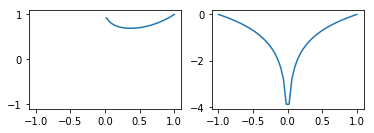

In [598]:
x = np.linspace(-1, 1, 50)

y = np.power(x, np.abs(x))

z = np.log(abs(x))

plt.subplot(221)
plt.plot(x, y)

plt.subplot(222)
plt.plot(x, z)

In [606]:
a = np.array([-10, -2, -3, 2, 3, 4])
np.r_[a , [1,2]]

array([-10,  -2,  -3,   2,   3,   4,   1,   2])

In [600]:
41/42

0.9761904761904762